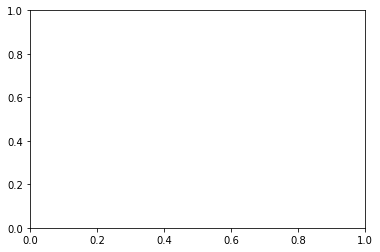

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

from functools import partial
from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

import chapter_2_results.tools_OF as tof

Bumblebees motion might differs to an ideal saccadic and gaze strategy, notably during the period where head movements along the YPR are supposed to be reduce to a minimum. Such residual movements will have an effect on the perceived optical flow. We want to see if the OF perceived by the bumblebee is resembling more to a motion parallay strategy (i.e. stabilized head, giving distance information in an egocentric reference frame) or a pivoting parllax strategy (i.e uni directional yaw rotation leading to a pivoting around a point in space, thus a geocentric representation of distance).

In a first step the perceived OF must be computed and the same must be done to simulated trajectories similar to a pivoting or motion parallax strategy computed in Notebook `chapter 2_di` and `chapter 2_dii`.


## Optic Flow

Optic flow is defined as the change of light in the image, thus the apparent motion of the environement on the retina.

In this section we focus on calculating the optic-flow from the insect motion and the distance to surrounding environement. We qualify the optic flow from known animal or camera motion and distance to surrounding objects as geometrical, and will call it geometrical optic flow or gOF. 

Koendering Van Dorn in their 1987 article 'Facts on optic flow' derive geometrical optic flow, and obtained the following equation

$$ gOF_i = -\mu_i(t-t. d_i)d_i)-R\times d_i $$

here 
* $gOF_i$ is the geometrical optic flow in the $i-th$ viewing direction $d_i$. 
* $t$ and $R$ are the translational and angular velocity, respectively. 
* $\mu_i$ is the nearness (inverse of the distance) to the closest object in the $i-th$ viewing direction

The equation can be rewritten by using the "apparent rotation" due to the translation $A_i=\mu_i di_i\times t$, and become

$$ gOF_i = -(A_i+R)\times d_i $$

The optic flow is thus the sum of apparent rotation due to the translation and the angular rotation projected to a plane orthogonal to the viewing direction. 

The eye of bees is an almost spherical apparatus, thus each viewing direction can be expressed in a spherical coordinate system. The gOF in a spherical system as three component, but the one along the viewing direction (i.e. the $\rho$ of the coordinate system) equates zero, because the gOF is othogonal to that direction.

We can calculate the rotational and translational optic flow components by using `navipy`

## Signal to noise ratio in optic flow

Thus, we will derive a signal to noise ratio as:

$$
snr = \frac{||gOF(signal)||}{||gOF(signal)-gOF(measure)||} 
$$


The signal is either:
* constantdrift : if the insect performs unidirectional yaw rotation during the intersaccade
* nulldrift : if the insect is stabilizing its head and perform pure translation

In [2]:
# Load list of bees
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
bee_ids = pd.read_hdf(head_filename_result,key='flight_ids')
# Load the results from splitted nonans
head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5'
# The simulated motion
head_filename_simulated_motion = 'chapter_2_results/idealmotion.hdf'

# Example

In [3]:
signaltype = 'constantdrift'
beeid = '17'
blk_i = 0

In [4]:
head_traj, res_sac_head = tof.load_data(signaltype,
             head_filename_result,
             head_filename_result_blocknonans,
             head_filename_simulated_motion,
             beeid,blk_i)

In [5]:
lamb = pd.Series(index=head_traj['measure'].columns, data=150)
for key in head_traj.keys():
    head_traj[key].filt_cspline(lamb)

/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [6]:
posvel = {name:tof.calculate_posvel(ht) for name, ht in head_traj.items()}
posvel = {name:tof.filter_unrealistic_speed(ht) for name, ht in posvel.items()}

Series([], dtype: float64)
Series([], dtype: float64)


# OF at nest and exit hole

In [7]:
arena_points = pd.Series(data=[0,0,0,0,-350,120], 
                         index=pd.MultiIndex.from_product([['nest','exit'],['x','y','z']]))
arena_points

nest  x      0
      y      0
      z      0
exit  x      0
      y   -350
      z    120
dtype: int64

To calculate the apparent motion (latter called inappropriately optic flow, or of) of these two arena points, we need to know the viewing direction of these points over time.

We, therefore, transform the points into the bumblebee coordinates system and then change the result in spherical coordinates. We thus obtain: the elevation, the azimuth and the radius (or distance between the bee and the point).

In [8]:
points2bee_sh = {name:tof.get_pointsonretina(ht, arena_points) for name, ht in head_traj.items()}

## calculate OF at the two points

In [9]:
optic_flow=dict()
for name in head_traj.keys():
    optic_flow[name] = tof.calc_of(posvel[name],points2bee_sh[name])
    if optic_flow[name] is None:
         break

In [10]:
optic_flow[name].unstack().unstack(level='Axis').apply(np.linalg.norm,axis=1).head()

Poi   Component   frame_i
exit  rotational  337.0      0.002262
                  338.0      0.003975
                  339.0      0.004996
                  340.0      0.005367
                  341.0      0.005430
dtype: float64

**qualitative test** To check if the optic flow of the next and exit has not been swapped we can look at the norm of the translational optic flow. It must be higher for the nest than for the exit, because the nest is closer to the bee than the exit

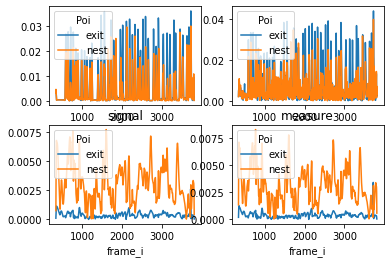

In [11]:
ofnorms = {name:optic_flow[name].unstack().unstack(level='Axis').apply(np.linalg.norm,axis=1) \
           for name,of in optic_flow.items()}


fig, axarr = plt.subplots(2,2)
for ii, (name,toplot) in enumerate(ofnorms.items()):
    ax = axarr[0,ii]
    toplot.unstack().transpose().xs('rotational',axis=1,level='Component').plot(ax=ax)
    ax = axarr[1,ii]
    toplot.unstack().transpose().xs('translation',axis=1,level='Component').plot(ax=ax)
    ax.set_title(name)

### Average optic flow during intersaccade/saccade

We want to average the optic flow during the intersaccade and saccade in order to reduce the effect of the noise. We first rearange the optic flow as two variables, optic flow saccade and intersaccade, because averages will be performed block-wise, saccade | intersaccade

In [12]:
optic_flow_intersac, optic_flow_saccade = tof.of_reindex_sacintersac(optic_flow,res_sac_head)
# The noise is simply the measure minus the signal
optic_flow_intersac['noise'] = optic_flow_intersac['measure'] - optic_flow_intersac['signal']

## Average 

In [13]:
of_intersac_mean = {name:of.groupby('intersac_i').apply(np.mean) for name,of in optic_flow_intersac.items()}
of_intersac_mean['measure'].head()

Poi             exit                nest          
Axis               h         v         h         v
intersac_i                                        
0.0         0.000714 -0.000627  0.004541  0.000057
1.0         0.002549 -0.000571  0.003428 -0.003761
2.0         0.001420 -0.000127 -0.003034 -0.006309
3.0        -0.000312  0.000284 -0.002638 -0.002367
4.0         0.001127  0.003505 -0.007070  0.001057

## norm

In [14]:
of_intersac_norm = {name:of.unstack().groupby(['Poi','intersac_i']).apply(np.linalg.norm) for name, of in of_intersac_mean.items()}
of_intersac_norm['measure'].head()

Poi   intersac_i
exit  0.0           0.000950
      1.0           0.002612
      2.0           0.001426
      3.0           0.000422
      4.0           0.003682
dtype: float64

In [15]:
# Signal to noise ratio
noise = ((of_intersac_norm['measure']-of_intersac_norm['signal']).abs())
snr_ofnorms_intsac = of_intersac_norm['signal']/noise
snr = pd.concat([snr_ofnorms_intsac.unstack().transpose()],axis=1,keys=['intersac'])

# Compare to result from function

We created a function `get_signal2noise_ratio_signaltype` that replicate the steps above. 

In [16]:
snr_function = tof.get_signal2noise_ratio_signaltype(signaltype, 
                                                 head_filename_result,
                                                 head_filename_result_blocknonans,
                                                 head_filename_simulated_motion,
                                                 beeid,blk_i,arena_points)

/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)


In [17]:
np.testing.assert_almost_equal(snr_function.values, snr.values)

 Storing location of SNR results

In [18]:
fname_temp = 'chapter_2_results/snr_{}.hdf'

In [19]:
functions = dict()
functions['constantdrift'] = partial(tof.get_signal2noise_ratio_signaltype, signaltype='constantdrift')
functions['nulldrift'] = partial(tof.get_signal2noise_ratio_signaltype, signaltype='nulldrift')

In [20]:
def all_bee_snr(myfunc, arena_points):
    # Load list of flights
    # As before the example above
    # Load list of bees
    head_filename_result = 'chapter_1_results/head_thorax_data.h5'
    bee_ids = pd.read_hdf(head_filename_result,key='flight_ids')
    # Load the results from splitted nonans
    head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5'
    # The simulated motion
    head_filename_simulated_motion = 'chapter_2_results/idealmotion.hdf'
    p = Pool()
    # Create a dictionary to store result
    # as flight | block
    snr = dict()
    # Loops through the flights
    for _, beeid in tqdm(bee_ids.iteritems(), total=bee_ids.shape[0], desc='beeid'):
        print(beeid) # Just to show a bit of progress
        # Load block no nans to loop through each block
        key = '/blk_nonans/flight_{}'.format(beeid)
        blknonans = pd.read_hdf(head_filename_result_blocknonans, key)
        snr[beeid] = dict()
        # Loop through the block
        for blk_i, _ in blknonans.iterrows():
            print('\t', blk_i) # Just to show a bit of progress
            out = myfunc(head_filename_result=head_filename_result, 
                         head_filename_result_blocknonans=head_filename_result_blocknonans,
                         head_filename_simulated_motion=head_filename_simulated_motion,
                         beeid=beeid, 
                         blk_i=blk_i, 
                         arena_points=arena_points,
                         p=p)
            if out is not None:
                snr[beeid][blk_i] = out
    p.close()
    # Merge all dictonary in a multiindexed dataframe
    snr_merge = dict()
    for key, val in snr.items():
        snr_merge[key] = pd.concat(val)
    snr_merge = pd.concat(snr_merge)
    
    # rename
    return snr_merge

In [21]:
for mode, func in functions.items():
    # The actual filename
    fname = fname_temp.format(mode)
    results = all_bee_snr(func, arena_points)
    results = results.stack(0)
    results.index.names = ['flight_i', 'blk_i', 'intersac_i', 'mvt']
    results.to_hdf(fname, 'snr')

05
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 2


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 3


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
06
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 2


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
07
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
08
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 2


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 3


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 4


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 5
5334.0    2.221123
5335.0    2.352642
dtype: float64
5333.0    2.529804
5334.0    3.235100
5335.0    3.475773
dtype: float64


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


	 6


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
11
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 2
Series([], dtype: float64)
Series([], dtype: float64)


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


	 3


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 4


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
17
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)



05
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 2


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 3
Series([], dtype: float64)
Series([], dtype: float64)


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


06
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 2


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
07
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
08
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 2


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 3


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 4


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 5
5334.0    2.221123
5335.0    2.352642
dtype: float64
5333.0    2.529804
5334.0    3.235100
5335.0    3.475773
dtype: float64


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


	 6


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
11
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 2
Series([], dtype: float64)
Series([], dtype: float64)


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


	 3


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 4


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
17
	 0


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)
	 1


/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Series([], dtype: float64)
Series([], dtype: float64)

